In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from lightfm.evaluation import precision_at_k
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

In [2]:
THREADS = 8

In [3]:
model = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/warp_model_1000_epochs_regularized.pkl')

## Precision

In [4]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz')

FileNotFoundError: [Errno 2] No such file or directory: '/pio/scratch/1/i313924/lightfm_data/slim_interactions.npz'

In [ ]:
# Super time-consuming: https://github.com/lyst/lightfm/issues/510
precision_at_k(model, interactions, k=5, num_threads=THREADS).mean()

## ABX utils

In [4]:
def analyse_ABX(path, tsne = None, pca = None):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 100))
    B = np.zeros((10000, 100))
    X = np.zeros((10000, 100))

    for i, test in tqdm(abx_tests.iterrows()):
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in tqdm(range(10000)):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    if tsne is not None:
        tsne_A = np.zeros((10000, 2))
        tsne_B = np.zeros((10000, 2))
        tsne_X = np.zeros((10000, 2))

        for i, test in tqdm(abx_tests.iterrows()):
            tsne_A[i, :] = tsne.loc[test["A"]]
            tsne_B[i, :] = tsne.loc[test["B"]]
            tsne_X[i, :] = tsne.loc[test["X"]]


        dist_tsne_A = ((tsne_A - tsne_X)**2).sum(axis=1)
        dist_tsne_B  = ((tsne_B - tsne_X)**2).sum(axis=1)

        cos_dist_tsne_A = np.zeros(10000)
        cos_dist_tsne_B = np.zeros(10000)

        for i in tqdm(range(10000)):
            cos_dist_tsne_A[i] = spatial.distance.cosine(tsne_A[i, :], tsne_X[i, :])
            cos_dist_tsne_B[i] = spatial.distance.cosine(tsne_B[i, :], tsne_X[i, :])

    print("Eucl:")
    print("Score: ", (dist_A < dist_B).mean())
    if pca is not None:
        print("PCA score: ", (dist_pca_A < dist_pca_B).mean())
        print("PCA distance match: ", ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (dist_tsne_A < dist_tsne_B).mean())
        print("tSNE distance match: ", ((dist_A < dist_B) == (dist_tsne_A < dist_tsne_B)).mean())

    print("Cos:",)
    print("Score: ", (cos_dist_A < cos_dist_B).mean())
    if pca is not None:
        print("PCA score: ", (cos_dist_pca_A < cos_dist_pca_B).mean())
        print("PCA distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean())
    if tsne is not None:
        print("tSNE score: ", (cos_dist_tsne_A < cos_dist_tsne_B).mean())
        print("tSNE distance match: ", ((cos_dist_A < cos_dist_B) == (cos_dist_tsne_A < dist_tsne_B)).mean())

In [5]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
items_embeddings = pd.DataFrame(model.item_embeddings)
items_embeddings = items_embeddings.rename(index=item_mapping)

user_embeddings = pd.DataFrame(model.user_embeddings)
embeddings = pd.concat([items_embeddings, user_embeddings], keys=['items', 'users'])
pca = PCA(n_components=2)
pca.fit(embeddings)

PCA(n_components=2)

## ABX (only popular)

In [6]:
analyse_ABX('/pio/scratch/1/i313924/data/test_data/test_ABX_weighted_slim.json', pca=pca)

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Eucl:
Score:  0.5906
PCA score:  0.6943
PCA distance match:  0.7239
Cos:
Score:  0.7039
PCA score:  0.6853
PCA distance match:  0.74


## Embeddings PCA

In [7]:
reduced_item_embeddings = pd.DataFrame(pca.transform(embeddings.loc["items"]))
reduced_user_embeddings = pd.DataFrame(pca.transform(embeddings.loc["users"]))

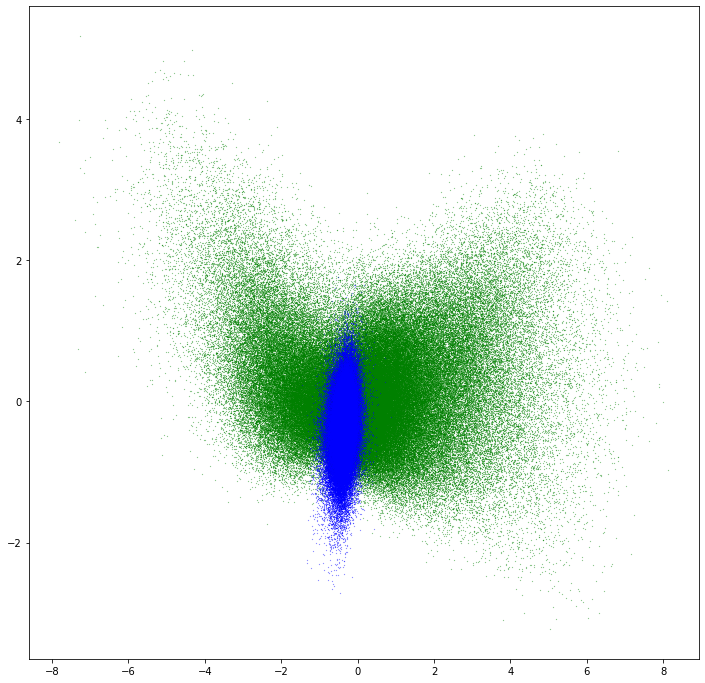

In [8]:
plt.figure(figsize=(12, 12))
plt.scatter(reduced_item_embeddings[0], reduced_item_embeddings[1], c='green', s=0.03)
plt.scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], c='blue', s=0.03)

In [9]:
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
user_mapping = {v: k for k, v in dataset.mapping()[0].items()}

In [10]:
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

In [11]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [12]:
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))

In [13]:
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

/pio/scratch/1/i313924/miniconda3/envs/venv/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


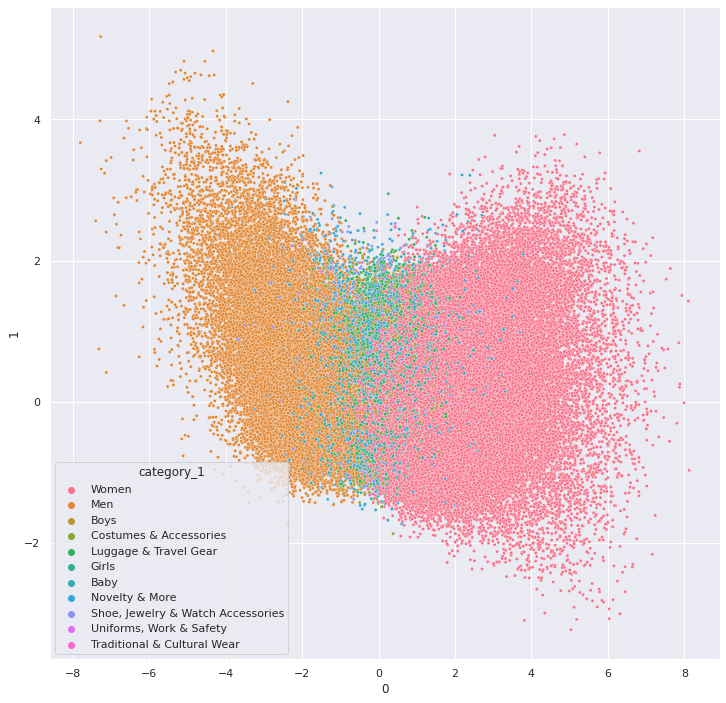

In [14]:
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10)

In [ ]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=5).set(xlim=(-5,5),ylim=(-5,5))

In [16]:
women_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Women']
men_embeddings = reduced_item_embeddings[reduced_item_embeddings['category_1'] == 'Men']

[(-5.0, 5.0), (-5.0, 5.0)]

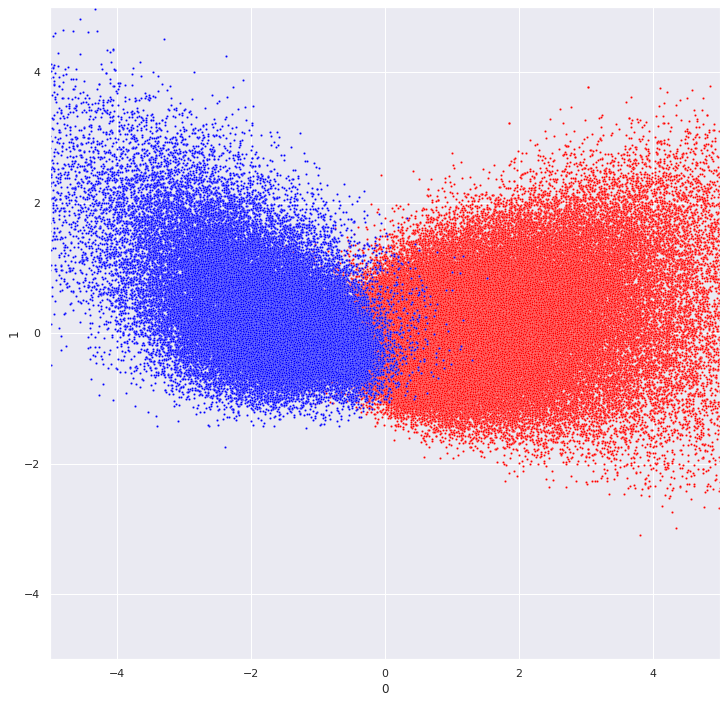

In [38]:
sns.scatterplot(x='0', y='1', data=women_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=men_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))

[(-5.0, 5.0), (-5.0, 5.0)]

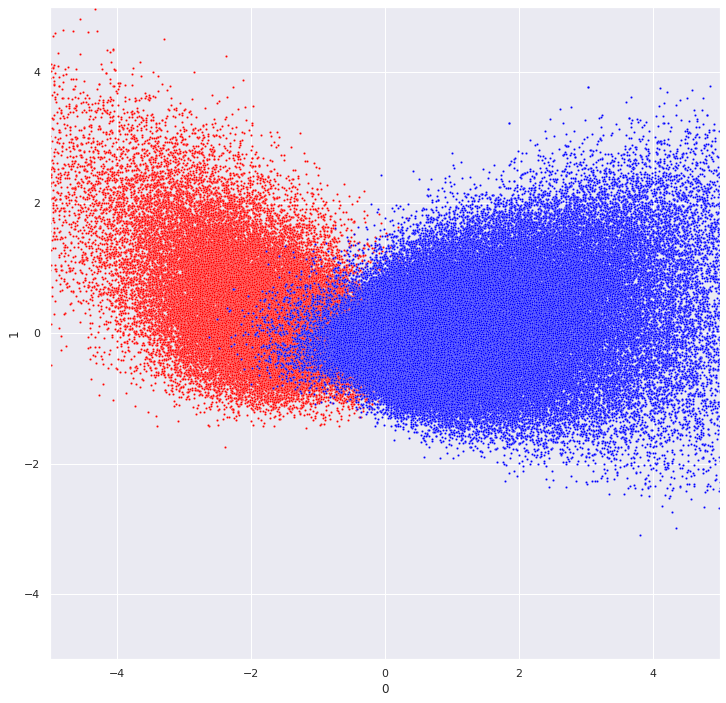

In [37]:
sns.scatterplot(x='0', y='1', data=men_embeddings, color='red', s=5).set(xlim=(-5,5),ylim=(-5,5))
sns.scatterplot(x='0', y='1', data=women_embeddings, color='blue', s=5).set(xlim=(-5,5),ylim=(-5,5))

## KNN

In [18]:
neigh = NearestNeighbors(n_neighbors=4)

In [19]:
samples = reduced_item_embeddings[['0', '1']].to_numpy()

In [20]:
neigh.fit(samples)

NearestNeighbors(n_neighbors=4)

In [21]:
women_nns = {}
for i in tqdm(range(len(women_embeddings))):
    women_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(women_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/102459 [00:00<?, ?it/s]

In [22]:
women_not_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is None or women_count < 2:
        women_not_nearest += 1

In [23]:
women_not_nearest / len(women_embeddings) * 100

20.32520325203252

In [24]:
men_nearest = 0
for _, v in women_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is not None and men_count >= 2:
        men_nearest += 1

In [25]:
men_nearest / len(women_embeddings) * 100

1.841712294673967

In [26]:
men_nns = {}
for i in tqdm(range(len(men_embeddings))):
    men_nns[i] = reduced_item_embeddings.iloc[neigh.kneighbors(men_embeddings[['0', '1']].to_numpy()[i, :].reshape(1, -1))[1][0][1:]]['category_1'].values

  0%|          | 0/51810 [00:00<?, ?it/s]

In [27]:
men_not_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    men_count = dict(zip(u, c)).get('Men')
    if men_count is None or men_count < 2:
        men_not_nearest += 1

In [28]:
men_not_nearest / len(men_embeddings) * 100

21.403204014668983

In [29]:
women_nearest = 0
for _, v in men_nns.items():
    u, c = np.unique(v, return_counts=True)
    women_count = dict(zip(u, c)).get('Women')
    if women_count is not None and women_count >= 2:
        women_nearest += 1

In [30]:
women_nearest / len(men_embeddings) * 100

3.0824165219069677